In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import yaml
import pandas as pd
from kitti_util import *

# ==============================================================================
#                                                         POINT_CLOUD_2_BIRDSEYE
# ==============================================================================
def point_cloud_2_top(points,
                      res=0.1,
                      zres=0.3,
                      side_range=(-20., 20-0.05),  # left-most to right-most
                      fwd_range=(0., 40.-0.05),  # back-most to forward-most
                      height_range=(-2., 0.),  # bottom-most to upper-most
                      ):
    """ Creates an birds eye view representation of the point cloud data for MV3D.
    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z
        res:        (float)
                    Desired resolution in metres to use. Each output pixel will
                    represent an square region res x res in size.
        zres:        (float)
                    Desired resolution on Z-axis in metres to use.
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        height_range: (tuple of two floats)
                    (min, max) heights (in metres) relative to the origin.
                    All height values will be clipped to this min and max value,
                    such that anything below min will be truncated to min, and
                    the same for values above max.
    Returns:
        numpy array encoding height features , density and intensity.
    """
    # EXTRACT THE POINTS FOR EACH AXIS
    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]
    reflectance = points[:,3]

    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = int((side_range[1] - side_range[0]) / res)
    y_max = int((fwd_range[1] - fwd_range[0]) / res)
    z_max = int((height_range[1] - height_range[0]) / zres)
    top = np.zeros([y_max+1, x_max+1, z_max+1], dtype=np.float32)

    # FILTER - To return only indices of points within desired cube
    # Three filters for: Front-to-back, side-to-side, and height ranges
    # Note left side is positive y axis in LIDAR coordinates
    f_filt = np.logical_and(
        (x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt = np.logical_and(
        (y_points > -side_range[1]), (y_points < -side_range[0]))
    filt = np.logical_and(f_filt, s_filt)

    for i, height in enumerate(np.arange(height_range[0], height_range[1], zres)):

        z_filt = np.logical_and((z_points >= height),
                                (z_points < height + zres))
        zfilter = np.logical_and(filt, z_filt)
        indices = np.argwhere(zfilter).flatten()

        # KEEPERS
        xi_points = x_points[indices]
        yi_points = y_points[indices]
        zi_points = z_points[indices]
        ref_i = reflectance[indices]

        # CONVERT TO PIXEL POSITION VALUES - Based on resolution
        x_img = (-yi_points / res).astype(np.int32)  # x axis is -y in LIDAR
        y_img = (-xi_points / res).astype(np.int32)  # y axis is -x in LIDAR

        # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
        # floor & ceil used to prevent anything being rounded to below 0 after
        # shift
        x_img -= int(np.floor(side_range[0] / res))
        y_img += int(np.floor(fwd_range[1] / res))

        # CLIP HEIGHT VALUES - to between min and max heights
        pixel_values = zi_points - height_range[0]
        # pixel_values = zi_points

        # FILL PIXEL VALUES IN IMAGE ARRAY
        top[y_img, x_img, i] = pixel_values

        # max_intensity = np.max(prs[idx])
        top[y_img, x_img, z_max] = ref_i
        
    top = (top / np.max(top) * 255).astype(np.uint8)
    return top

def transform_to_img(xmin, xmax, ymin, ymax,
                      res=0.1,
                      side_range=(-20., 20-0.05),  # left-most to right-most
                      fwd_range=(0., 40.-0.05),  # back-most to forward-most
                      ):

    xmin_img = -ymax/res - side_range[0]/res
    xmax_img = -ymin/res - side_range[0]/res
    ymin_img = -xmax/res + fwd_range[1]/res
    ymax_img = -xmin/res + fwd_range[1]/res
    
    return xmin_img, xmax_img, ymin_img, ymax_img

/home/ubuntu/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/ubuntu/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/ubuntu/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/ubuntu/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/ubuntu/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: RuntimeWarni

In [2]:
def draw_point_cloud(ax, points, axes=[0, 1, 2], point_size=0.1, xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    axes_limits = [
        [-20, 80], # X axis range
        [-20, 20], # Y axis range
        [-3, 3]   # Z axis range
    ]
    axes_str = ['X', 'Y', 'Z']
    ax.grid(False)
    
    ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:, 3], cmap='gray')
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)
        
def compute_3d_box_cam2(h, w, l, x, y, z, yaw):
    """
    Return : 3xn in cam2 coordinate
    """
    R = np.array([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]])
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2]
    corners_3d_cam2 = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
    corners_3d_cam2 += np.vstack([x, y, z])
    return corners_3d_cam2

def draw_box(ax, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        ax.plot(*vertices[:, connection], c=color, lw=0.5)

In [14]:
def read_detection(path):
    df = pd.read_csv(path, header=None, sep=' ')
    df.columns = ['type', 'truncated', 'occluded', 'alpha', 'bbox_left', 'bbox_top',
                'bbox_right', 'bbox_bottom', 'height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']
#     df.loc[df.type.isin(['Truck', 'Van', 'Tram']), 'type'] = 'Car'
#     df = df[df.type.isin(['Car', 'Pedestrian', 'Cyclist'])]
    df = df[df['type']=='Car']
    df.reset_index(drop=True, inplace=True)
    return df

img_id = 120

calib = Calibration('/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/calib/%06d.txt'%img_id)

path = '/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/velodyne/%06d.bin'%img_id
points = np.fromfile(path, dtype=np.float32).reshape(-1, 4)

df = read_detection('/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/label_2/%06d.txt'%img_id)
df.head()

,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
0,Car,0.06,1,2.04,57.05,202.42,394.68,374.00,1.42,1.67,3.80,-3.91,1.82,8.06,1.60
1,Car,1.00,0,2.56,0.00,210.49,119.82,374.00,1.55,1.71,4.50,-4.09,1.78,2.42,1.57
2,Car,0.00,0,1.25,814.15,164.79,997.27,262.07,1.50,1.71,4.44,5.18,1.40,13.43,1.61
3,Car,0.00,1,1.86,346.63,185.82,485.85,278.21,1.54,1.63,3.59,-3.68,1.82,14.17,1.61
4,Car,0.00,1,1.76,455.26,186.71,532.19,243.46,1.42,1.46,3.63,-3.24,1.84,20.44,1.61


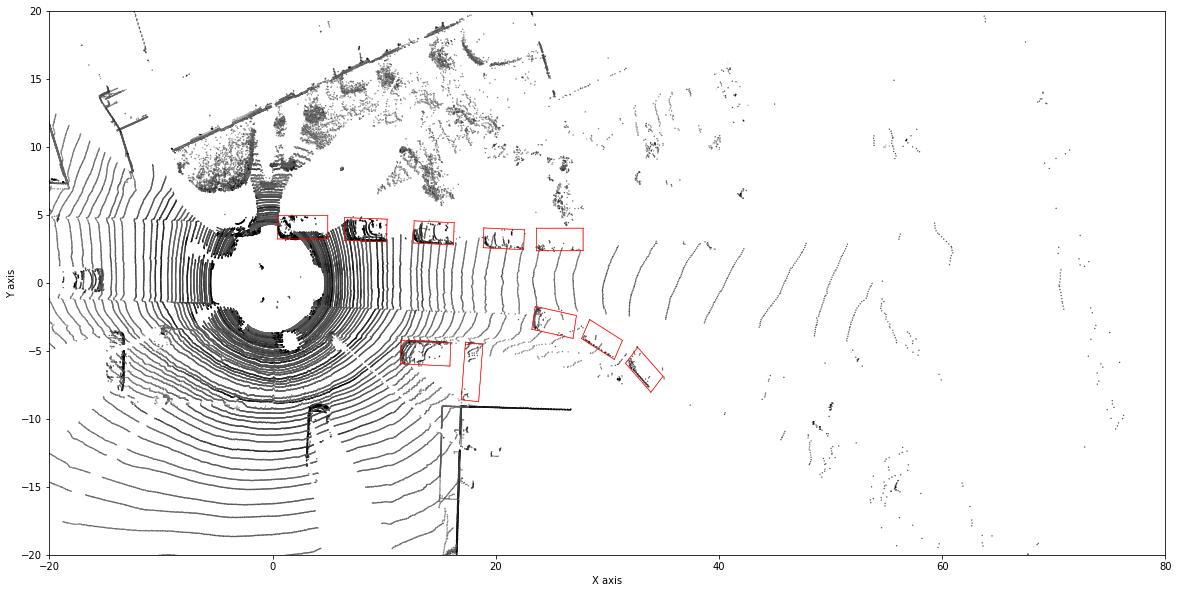

In [15]:
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(40, 150)
# draw_point_cloud(ax, points[::5])

fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points, axes=[0, 1])
for o in range(len(df)):
    corners_3d_cam2 = compute_3d_box_cam2(*df.loc[o, ['height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']])
    draw_box(ax, calib.project_rect_to_velo(corners_3d_cam2.T).T, axes=[0, 1], color='r')

(400, 400, 3)


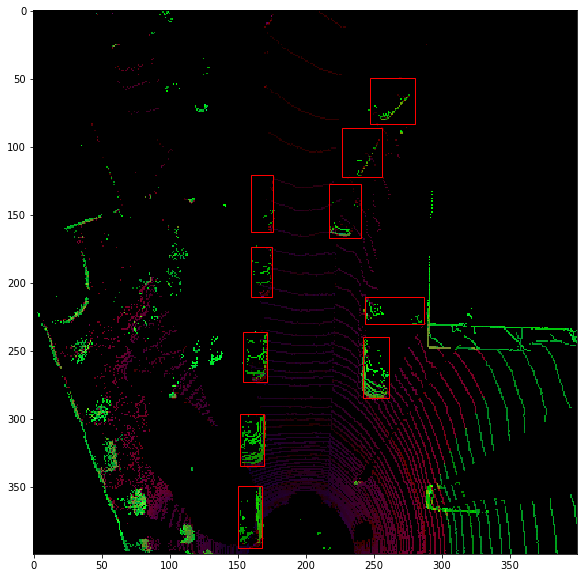

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
top = point_cloud_2_top(points, zres=1.0)
print(top.shape)
for o in range(len(df)):
    corners_3d_cam2 = compute_3d_box_cam2(*df.loc[o, ['height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']])
    corners_3d_velo = calib.project_rect_to_velo(corners_3d_cam2.T).T
    xmax = np.max(corners_3d_velo[0, :4])
    xmin = np.min(corners_3d_velo[0, :4])
    ymax = np.max(corners_3d_velo[1, :4])
    ymin = np.min(corners_3d_velo[1, :4])
    xmin_img, xmax_img, ymin_img, ymax_img = transform_to_img(xmin, xmax, ymin, ymax)
    rect = patches.Rectangle((xmin_img,ymin_img),xmax_img-xmin_img,ymax_img-ymin_img,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.imshow(top)

# Create data

In [ ]:
from __future__ import print_function

for img_id in range(7481):
    df = read_detection('/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/label_2/%06d.txt'%img_id)
    calib = Calibration('/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/calib/%06d.txt'%img_id)

    path = '/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/velodyne/%06d.bin'%img_id
    points = np.fromfile(path, dtype=np.float32).reshape(-1, 4)

    top = point_cloud_2_top(points, zres=1.0)
    img_h, img_w, _ = top.shape
    plt.imsave('data/images/%06d.png'%img_id, top)
    df_ = pd.DataFrame()
    for o in range(len(df)):
        corners_3d_cam2 = compute_3d_box_cam2(*df.loc[o, ['height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']])
        corners_3d_velo = calib.project_rect_to_velo(corners_3d_cam2.T).T
        xmax = np.max(corners_3d_velo[0, :4])
        xmin = np.min(corners_3d_velo[0, :4])
        ymax = np.max(corners_3d_velo[1, :4])
        ymin = np.min(corners_3d_velo[1, :4])
        xmin_img, xmax_img, ymin_img, ymax_img = transform_to_img(xmin, xmax, ymin, ymax)
        xmin_img = max(0, xmin_img)
        ymin_img = max(0, ymin_img)
        xmax_img = min(img_w, xmax_img)
        ymax_img = min(img_h, ymax_img)
        if xmin_img >= img_w or xmax_img <= 0 or ymin_img >= img_h or ymax_img <= 0:
            continue
        df_ = df_.append({'XMin':xmin_img, 'XMax':xmax_img, 'YMin':ymin_img, 'YMax':ymax_img}, ignore_index=True)
    df_.to_csv('data/labels/%06d.csv'%img_id)
    print('\r', img_id, end=' '*10)

 7335                   